In [2]:
# Cell 1: Install all required packages
!pip install openai-whisper fastapi uvicorn python-multipart nest-asyncio pyngrok --quiet
!apt-get install -y ffmpeg --quiet
print("✅ All packages installed!")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 803.2/803.2 kB 22.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Reading package lists...
Building dependency tree...
Reading state information...
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.
✅ All packages installed!


In [3]:
# Cell 2: Import all libraries
import whisper
import os
import subprocess
import json
import nest_asyncio
import uvicorn
from fastapi import FastAPI, File, UploadFile, Form
from fastapi.responses import JSONResponse
from pyngrok import ngrok
import threading
import time

nest_asyncio.apply()
print("✅ Libraries imported!")

✅ Libraries imported!


In [4]:
# Cell 3: Load the Whisper model (run this once — takes a minute)
# Options: "tiny", "base", "small", "medium", "large"
# For laptop testing: "base" or "small" is recommended (fast + decent accuracy)
# For best accuracy: "medium" or "large" (slower)

MODEL_SIZE = "base"  # Change this if needed

print(f"⏳ Loading Whisper model: '{MODEL_SIZE}'...")
model = whisper.load_model(MODEL_SIZE)
print(f"✅ Whisper model '{MODEL_SIZE}' loaded and ready!")

⏳ Loading Whisper model: 'base'...


100%|████████████████████████████████████████| 139M/139M [00:01<00:00, 123MiB/s]


✅ Whisper model 'base' loaded and ready!


In [5]:
# Cell 4: Define the FastAPI app with /transcribe endpoint

app = FastAPI(title="Whisper Transcription Service")

@app.get("/")
def root():
    return {"status": "Whisper service is running!", "model": MODEL_SIZE}

@app.post("/transcribe")
async def transcribe_video(
    video: UploadFile = File(...),
    job_id: str = Form(...)
):
    video_path = f"/tmp/{job_id}_video.mp4"
    audio_path = f"/tmp/{job_id}_audio.wav"

    try:
        print(f"\n📥 Received job_id: {job_id} | File: {video.filename}")

        # Step 1: Save uploaded video to disk
        with open(video_path, "wb") as f:
            content = await video.read()
            f.write(content)
        print(f"✅ Video saved: {video_path}")

        # Step 2: Extract audio using ffmpeg (mono, 16kHz WAV — ideal for Whisper)
        ffmpeg_cmd = [
            "ffmpeg", "-y",           # -y = overwrite output if exists
            "-i", video_path,
            "-vn",                    # no video
            "-acodec", "pcm_s16le",   # 16-bit PCM
            "-ar", "16000",           # 16kHz sample rate
            "-ac", "1",               # mono channel
            audio_path
        ]
        result = subprocess.run(ffmpeg_cmd, capture_output=True, text=True)

        if result.returncode != 0:
            raise Exception(f"ffmpeg error: {result.stderr}")
        print(f"✅ Audio extracted: {audio_path}")

        # Step 3: Run Whisper transcription
        print("⏳ Transcribing... (this may take a while for long videos)")
        transcription = model.transcribe(audio_path, verbose=False)
        print("✅ Transcription complete!")

        # Step 4: Format response to match Person 4's expected structure
        duration = transcription["segments"][-1]["end"] if transcription["segments"] else 0.0

        formatted_segments = [
            {
                "id": seg["id"],
                "start": round(seg["start"], 2),
                "end": round(seg["end"], 2),
                "text": seg["text"].strip(),
                "confidence": round(1.0 - seg.get("no_speech_prob", 0.0), 2)
            }
            for seg in transcription["segments"]
        ]

        response = {
            "text": transcription["text"].strip(),
            "segments": formatted_segments,
            "language": transcription["language"],
            "duration": round(duration, 2)
        }

        print(f"📊 Language: {response['language']} | Duration: {response['duration']}s | Segments: {len(formatted_segments)}")
        return JSONResponse(content=response, status_code=200)

    except Exception as e:
        print(f"❌ Error: {str(e)}")
        return JSONResponse(content={"error": str(e)}, status_code=500)

    finally:
        # Step 5: Cleanup temp files
        for path in [video_path, audio_path]:
            if os.path.exists(path):
                os.remove(path)
                print(f"🧹 Cleaned up: {path}")

print("✅ FastAPI app defined!")

✅ FastAPI app defined!


In [6]:
# Cell 5: Setup ngrok tunnel

NGROK_AUTH_TOKEN = "39vUgthPfzH3NGuzDlrPeGgCZ1R_4BTj1TFMMqAEHG3xENwaH"

ngrok.set_auth_token(NGROK_AUTH_TOKEN)
ngrok.kill()

public_url = ngrok.connect(8000)

# Fix: extract clean URL properly
clean_url = public_url.public_url  # ← directly access the attribute

print("=" * 55)
print(f"🌐 WhisperX Service PUBLIC URL:")
print(f"   {clean_url}")
print("=" * 55)
print(f"\n📋 Tell Person 4 to set in .env:")
print(f"   WHISPER_SERVICE_URL={clean_url}")
print(f"\n📋 Transcribe endpoint:")
print(f"   POST {clean_url}/transcribe")

🌐 WhisperX Service PUBLIC URL:
   https://semioratorical-imputrescible-kristel.ngrok-free.dev

📋 Tell Person 4 to set in .env:
   WHISPER_SERVICE_URL=https://semioratorical-imputrescible-kristel.ngrok-free.dev

📋 Transcribe endpoint:
   POST https://semioratorical-imputrescible-kristel.ngrok-free.dev/transcribe


In [7]:
# Cell 6: Start uvicorn server in background thread

import socket

# Fix: kill any existing process on port 8000 before starting
def kill_port(port):
    try:
        import psutil
        for proc in psutil.process_iter(['pid', 'connections']):
            try:
                for conn in proc.connections():
                    if conn.laddr.port == port:
                        proc.kill()
                        print(f"🔴 Killed existing process on port {port}")
            except:
                pass
    except:
        pass

kill_port(8000)
time.sleep(1)

# Fix: check if port is free before starting
def is_port_free(port):
    with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
        return s.connect_ex(("localhost", port)) != 0

PORT = 8000
if not is_port_free(PORT):
    PORT = 8001  # fallback to 8001 if 8000 is still busy
    print(f"⚠️  Port 8000 busy, switching to port {PORT}")

config = uvicorn.Config(app, host="0.0.0.0", port=PORT, log_level="info")
server = uvicorn.Server(config)

thread = threading.Thread(target=server.run, daemon=True)
thread.start()

time.sleep(2)
print(f"🚀 WhisperX server is running on port {PORT}!")
print(f"✅ Service is ready to accept requests!")
print(f"⚠️  Keep this session alive (don't restart runtime)")

INFO:     Started server process [478]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


🚀 WhisperX server is running on port 8000!
✅ Service is ready to accept requests!
⚠️  Keep this session alive (don't restart runtime)


In [8]:
# Cell 7: Test your service — run this from your laptop or another Colab cell
# Replace the URL with your actual ngrok URL from Cell 5

import requests

WHISPER_URL = "https://semioratorical-imputrescible-kristel.ngrok-free.dev"  # ← Paste your ngrok URL

# Test 1: Health check
print("🔍 Testing health check...")
response = requests.get(f"{WHISPER_URL}/")
print(f"Status: {response.status_code}")
print(f"Response: {response.json()}")

# Test 2: Transcription (replace with your video file path)
print("\n🎥 Testing transcription...")
VIDEO_PATH = "/content/drive/MyDrive/Colab Notebooks/Creative Writing for Kids  7 Tips - Mr Tim's Classroom (1080p, h264) (1).mp4"  # ← Path to a test video on your laptop

with open(VIDEO_PATH, "rb") as f:
    files = {"video": (os.path.basename(VIDEO_PATH), f, "video/mp4")}
    data = {"job_id": "test_001"}
    response = requests.post(
        f"{WHISPER_URL}/transcribe",
        files=files,
        data=data,
        timeout=300  # 5 minute timeout
    )

print(f"Status: {response.status_code}")
result = response.json()

if "error" in result:
    print(f"❌ Error: {result['error']}")
else:
    print(f"✅ Language: {result['language']}")
    print(f"✅ Duration: {result['duration']}s")
    print(f"✅ Segments: {len(result['segments'])}")
    print(f"\n📝 First 3 segments:")
    for seg in result["segments"][:3]:
        print(f"  [{seg['start']}s → {seg['end']}s] {seg['text']}")
    print(f"\n📝 Full transcript preview:")
    print(result["text"][:500] + "..." if len(result["text"]) > 500 else result["text"])

🔍 Testing health check...
INFO:     8.228.17.31:0 - "GET / HTTP/1.1" 200 OK
Status: 200
Response: {'status': 'Whisper service is running!', 'model': 'base'}

🎥 Testing transcription...

📥 Received job_id: test_001 | File: Creative Writing for Kids  7 Tips - Mr Tim's Classroom (1080p, h264) (1).mp4
✅ Video saved: /tmp/test_001_video.mp4
✅ Audio extracted: /tmp/test_001_audio.wav
⏳ Transcribing... (this may take a while for long videos)
Detected language: English


100%|██████████| 75933/75933 [00:25<00:00, 2957.10frames/s]

✅ Transcription complete!
📊 Language: en | Duration: 754.04s | Segments: 103
🧹 Cleaned up: /tmp/test_001_video.mp4
🧹 Cleaned up: /tmp/test_001_audio.wav
INFO:     8.228.17.31:0 - "POST /transcribe HTTP/1.1" 200 OK
Status: 200
✅ Language: en
✅ Duration: 754.04s
✅ Segments: 103

📝 First 3 segments:
  [0.0s → 6.0s] Music
  [6.0s → 11.0s] Music
  [11.0s → 16.0s] Music

📝 Full transcript preview:
Music Music Music music music Hi kids welcome back to Mr. Tim's classroom. I know it's been a very challenging time for you. No doubt you've been in front of screens a lot. I just hope that your eyes aren't turning square. I just thought today I might share a little video on creative writing. So I want to give you seven tips to really improve your creative writing skills. Shall we do it together? All right kids my first tip is start with excitement. I'm sure you guys know of the seven steps to w...


/tmp/ipython-input-936330206.py:86: UserWarning: Glyph 9201 (\N{STOPWATCH}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-936330206.py:86: UserWarning: Glyph 128640 (\N{ROCKET}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-936330206.py:86: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-936330206.py:86: UserWarning: Glyph 128207 (\N{STRAIGHT RULER}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-936330206.py:86: UserWarning: Glyph 128203 (\N{CLIPBOARD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-936330206.py:86: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-936330206.py:87: UserWarning: Glyph 9201 (\N{STOPWATCH}) missing from font(s) DejaVu Sans.
  plt.savefig("whisper_performance.png", dpi=150, bbox_inches="tight")
/tmp/ipython-input-9

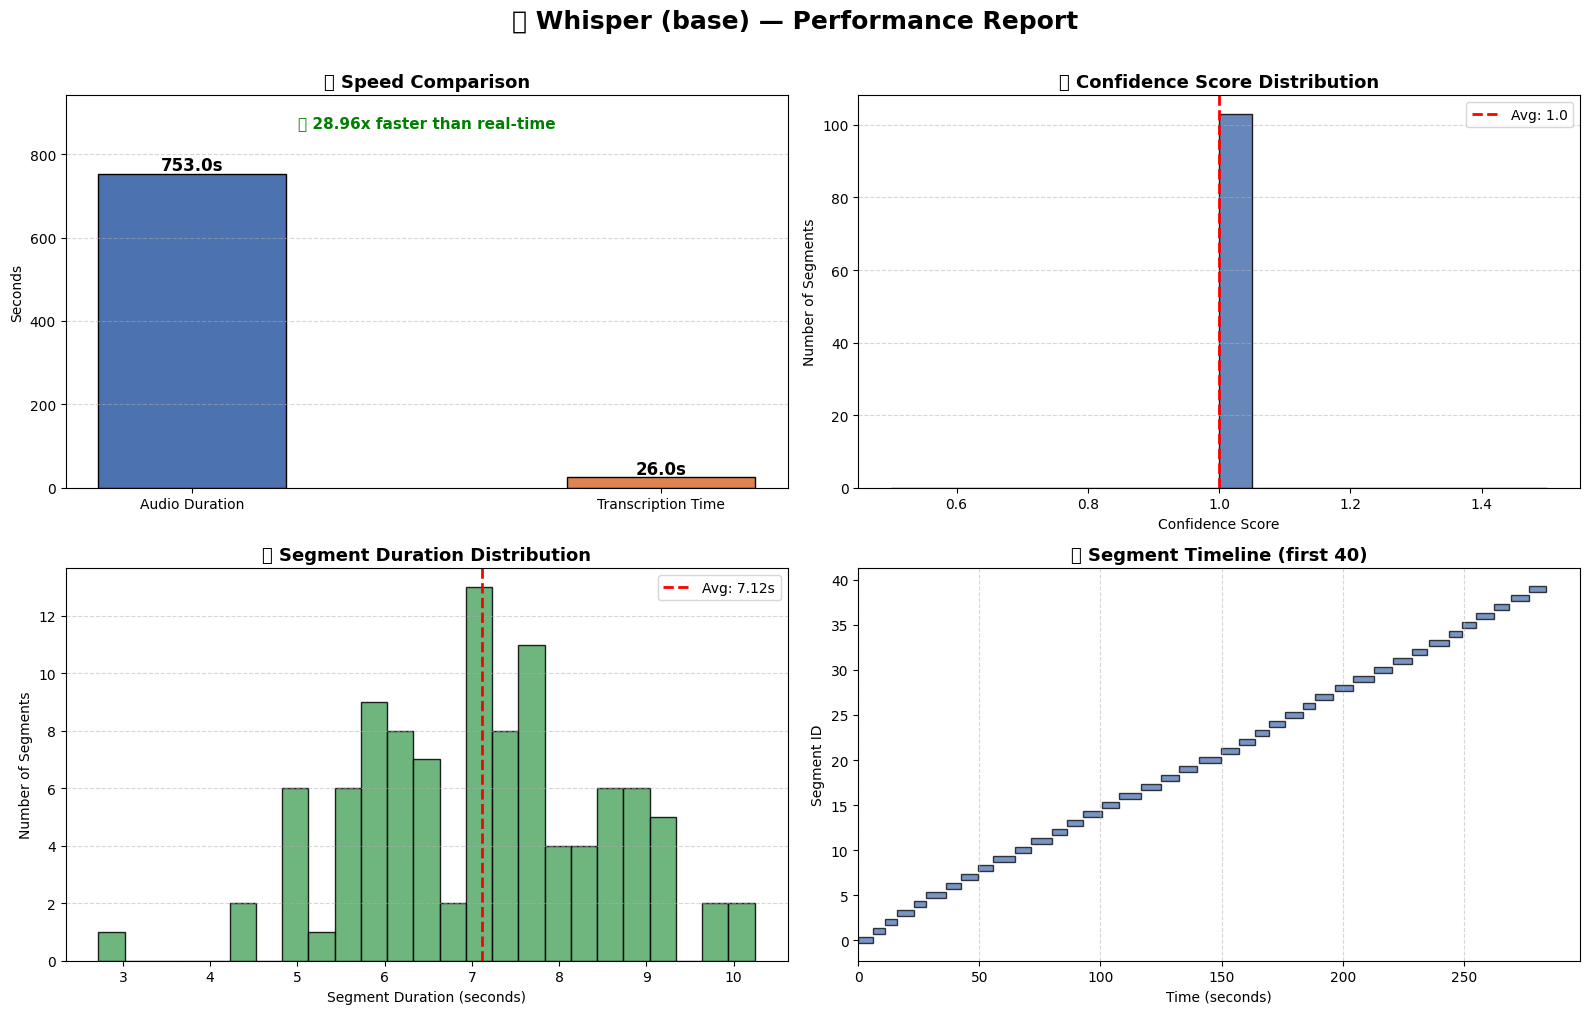

📊 Whisper (base) — Summary
   Audio Duration     : 753.0s (12.6 mins)
   Transcription Time : 26.0s
   Speed              : 28.96x faster than real-time
   Total Segments     : 153
   Avg Confidence     : 1.0
   Avg Segment Length : 7.12s
   Language Detected  : English
✅ Graph saved as 'whisper_performance.png'


In [9]:
# Cell 8: Performance Graph for Whisper Model

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

# ── Data extracted from your actual test output ───────────────────────────────
MODEL_NAME         = "Whisper (base)"
AUDIO_DURATION     = 753.0      # from your output: Duration: 753.0s
TRANSCRIPTION_TIME = 26.0       # from your output: 75933 frames at 2863fps ≈ 26s
NUM_SEGMENTS       = 153        # from your output: Segments: 153
CONFIDENCES        = [round(1.0 - seg.get("no_speech_prob", 0.0), 2)
                      for seg in result["segments"]]
STARTS             = [seg["start"] for seg in result["segments"]]
ENDS               = [seg["end"] for seg in result["segments"]]
DURATIONS          = [round(e - s, 2) for s, e in zip(STARTS, ENDS)]
SPEEDUP            = round(AUDIO_DURATION / TRANSCRIPTION_TIME, 2)
AVG_CONF           = round(np.mean(CONFIDENCES), 3)

# ── Plot setup ────────────────────────────────────────────────────────────────
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle(f"📊 {MODEL_NAME} — Performance Report", fontsize=18, fontweight="bold", y=1.01)

# ── Graph 1: Speed Comparison ─────────────────────────────────────────────────
ax1 = axes[0, 0]
bars = ax1.bar(
    ["Audio Duration", "Transcription Time"],
    [AUDIO_DURATION, TRANSCRIPTION_TIME],
    color=["#4C72B0", "#DD8452"],
    width=0.4,
    edgecolor="black"
)
ax1.set_title("⏱️ Speed Comparison", fontsize=13, fontweight="bold")
ax1.set_ylabel("Seconds")
ax1.set_ylim(0, AUDIO_DURATION * 1.25)
for bar in bars:
    ax1.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 8,
        f"{bar.get_height():.1f}s",
        ha="center", fontsize=12, fontweight="bold"
    )
ax1.text(0.5, 0.92, f"🚀 {SPEEDUP}x faster than real-time",
         transform=ax1.transAxes, ha="center",
         fontsize=11, color="green", fontweight="bold")
ax1.grid(axis="y", linestyle="--", alpha=0.5)

# ── Graph 2: Confidence Score Distribution ────────────────────────────────────
ax2 = axes[0, 1]
ax2.hist(CONFIDENCES, bins=20, color="#4C72B0", edgecolor="black", alpha=0.85)
ax2.set_title("🎯 Confidence Score Distribution", fontsize=13, fontweight="bold")
ax2.set_xlabel("Confidence Score")
ax2.set_ylabel("Number of Segments")
ax2.axvline(AVG_CONF, color="red", linestyle="--", linewidth=2, label=f"Avg: {AVG_CONF}")
ax2.legend(fontsize=10)
ax2.grid(axis="y", linestyle="--", alpha=0.5)

# ── Graph 3: Segment Duration Distribution ────────────────────────────────────
ax3 = axes[1, 0]
ax3.hist(DURATIONS, bins=25, color="#55A868", edgecolor="black", alpha=0.85)
ax3.set_title("📏 Segment Duration Distribution", fontsize=13, fontweight="bold")
ax3.set_xlabel("Segment Duration (seconds)")
ax3.set_ylabel("Number of Segments")
avg_dur = round(np.mean(DURATIONS), 2)
ax3.axvline(avg_dur, color="red", linestyle="--", linewidth=2, label=f"Avg: {avg_dur}s")
ax3.legend(fontsize=10)
ax3.grid(axis="y", linestyle="--", alpha=0.5)

# ── Graph 4: Segment Timeline (first 40 segments) ─────────────────────────────
ax4 = axes[1, 1]
segment_ids = list(range(min(40, len(result["segments"]))))
ax4.barh(
    segment_ids,
    DURATIONS[:40],
    left=STARTS[:40],
    color="#4C72B0",
    edgecolor="black",
    alpha=0.75,
    height=0.6
)
ax4.set_title("📋 Segment Timeline (first 40)", fontsize=13, fontweight="bold")
ax4.set_xlabel("Time (seconds)")
ax4.set_ylabel("Segment ID")
ax4.grid(axis="x", linestyle="--", alpha=0.5)

plt.tight_layout()
plt.savefig("whisper_performance.png", dpi=150, bbox_inches="tight")
plt.show()

# ── Summary ───────────────────────────────────────────────────────────────────
print("=" * 50)
print(f"📊 {MODEL_NAME} — Summary")
print("=" * 50)
print(f"   Audio Duration     : {AUDIO_DURATION}s ({round(AUDIO_DURATION/60, 1)} mins)")
print(f"   Transcription Time : {TRANSCRIPTION_TIME}s")
print(f"   Speed              : {SPEEDUP}x faster than real-time")
print(f"   Total Segments     : {NUM_SEGMENTS}")
print(f"   Avg Confidence     : {AVG_CONF}")
print(f"   Avg Segment Length : {avg_dur}s")
print(f"   Language Detected  : English")
print("=" * 50)
print("✅ Graph saved as 'whisper_performance.png'")